DATA SET SOURCES: 

SOURCE: https://www.kaggle.com/datasets/mariaren/covid19-healthy-diet-dataset

SOURCE: https://www.kaggle.com/datasets/kaggle/world-development-indicators

In [63]:
#Below imports the two datasets, and integrates them into a merged dataset, and writes a csv
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype

#DATA SET 1
df = pd.read_csv('./data/Fat_Supply_Quantity_Data.csv') #assuming in same directory

#remove unwanted columns from the dataframe
df = df.drop(['Alcoholic Beverages','Animal Products','Animal fats','Aquatic Products, Other',
              'Cereals - Excluding Beer','Eggs','Fish, Seafood','Fruits - Excluding Wine', 'Meat',
              'Miscellaneous','Milk - Excluding Butter','Offals','Oilcrops','Pulses', 'Spices',
              'Starchy Roots','Stimulants','Sugar Crops','Sugar & Sweeteners','Treenuts','Vegetal Products',
              'Vegetable Oils','Vegetables','Active','Unit (all except Population)'], axis=1)

#remove NAN entries from the dataframe
df = df.dropna()

#check all entries are valid for each field (they are all percentages, excluding population)
df=df[df['Population']>=0] #Population < 0

#undernourished has <2.5 for countries with very low undernourished rates,
#so will replace these string values with integer value 0
df['Undernourished'].mask(df['Undernourished'] == '<2.5', 0, inplace=True)

df = df.drop([])

#DATA SET 2
df_2 = pd.read_csv('./data/Country.csv')

df_2 = df_2.drop(['CountryCode','LongName','TableName','LatestTradeData','Alpha2Code',
                  'CurrencyUnit','SpecialNotes','Region','Wb2Code','NationalAccountsBaseYear',
                  'NationalAccountsReferenceYear','SnaPriceValuation','LendingCategory','OtherGroups',
                  'SystemOfNationalAccounts','AlternativeConversionFactor','PppSurveyYear',
                  'BalanceOfPaymentsManualInUse','ExternalDebtReportingStatus','SystemOfTrade',
                  'GovernmentAccountingConcept','ImfDataDisseminationStandard','LatestPopulationCensus',
                  'LatestHouseholdSurvey','SourceOfMostRecentIncomeAndExpenditureData','VitalRegistrationComplete',
                  'LatestAgriculturalCensus','LatestIndustrialData','LatestWaterWithdrawalData'],axis=1)

df_2['IncomeGroup'].replace('', np.nan, inplace=True)
df_2 = df_2.dropna()

#High income: nonOECD
#High income: OECD
df_2['IncomeGroup'].mask(df_2['IncomeGroup'] == 'High income: nonOECD', "High income", inplace=True)
df_2['IncomeGroup'].mask(df_2['IncomeGroup'] == 'High income: OECD', "High income", inplace=True)
#Categories remaining: Low income, High income, Lower middle income, Upper middle income
    
df_2.rename(columns = {'ShortName':'Country'}, inplace = True)

#join the two datasets
df_merged = pd.merge(df, df_2, how='inner', on='Country')
df_merged=df_merged.dropna()

#make undernourished numeric
df_merged['Undernourished']=pd.to_numeric(df_merged['Undernourished'],errors ='coerce')

is_numeric_dtype(df_merged['Undernourished'])

df_merged.to_csv("luke_dataset.csv",index=False)

print(df_merged.size) #just to show it created something

1072


#Initial Data Analysis using summary tables:

#The death rate to COVID-19 as a percentage of the total population for a country compared to the country’s income group (nominal attribute) was investigated using the following table:

In [64]:
#NOTE: To see imports and where df_merged is initialised, see source code in .zip folder:
temp_df = df_merged.groupby('IncomeGroup').mean()
temp_df = temp_df.drop(["Obesity","Confirmed","Recovered","Population","Undernourished"],axis=1)
temp_df.rename(columns = {'Deaths':'Death rate to COVID-19 (% of population)'}, inplace = True)
display(temp_df)

,Death rate to COVID-19 (% of population)
IncomeGroup,
High income,0.070841
Low income,0.002248
Lower middle income,0.019706
Upper middle income,0.048880


The table indicates that lower income countries have a lower death rate, which goes against the intuition that higher income countries would have greater access to medical facilities to reduce their death rate. Therefore, the lower income counties having a lower death rate is likely due to the fact that in late 2020 very few low income countries were accurately reporting COVID-19 deaths. Furthermore, the next investigations into the data will reveal how obesity in high income countries is a more significant contributor to the death rate than the income level of a country.


#How the obesity rate affects the death rate is investigated using the binned-quantitative table below:

In [65]:
#NOTE: To see imports and where df_merged is initialised, see source code in .zip folder:
df_temp = df_merged.drop(['Confirmed','Recovered','Population','Undernourished'],axis=1)
df_temp.rename(columns = {'Deaths':'Death rate to COVID-19 (% of population)'}, inplace = True)

print('max obesity is:',df_temp['Obesity'].max()) #max is 37, so just go to 40.
groups = df_temp.groupby(pd.cut(df_temp.Obesity, [1, 10, 20, 30, 40])).mean()
display(groups)

max obesity is: 37.0


,Obesity,Death rate to COVID-19 (% of population)
Obesity,,
"(1, 10]",6.142105,0.003482
"(10, 20]",15.979167,0.029731
"(20, 30]",24.993548,0.071075
"(30, 40]",32.470000,0.028499


The leftmost column is the obesity brackets, the middle obesity column is the average obesity rate in that bracket, and the right column is the resulting death rate to COVID-19. The table shows that in the brackets of 1-30%, a higher obesity rate leads to a higher death rate from COVID-19 for a country. The 30-40% bracket shows a decline in the death rate relative to the 20-30% bracket which is likely caused by there being less than 5 countries in the top bracket. The average across a small number of countries is not likely to be a reliable indicator of the real death rate for 30-40% obesity countries.


#Data Analysis using charts:

Chart 1: A chart was used to investigate how the income level and obesity rate of a country affects COVID death rate. The chart plots the obesity rate (y-axis) against the income groups (x-axis), with the death rate as the colour of the dots with a colour gradient used to encode the death rate:

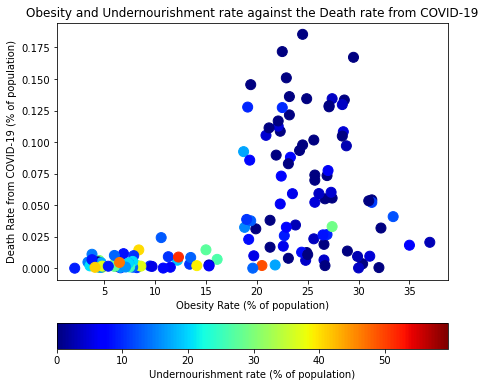

In [66]:
#Obesity rate against death rate, with undernourishment as the colour of the points
#NOTE: df_merged is a pandas dataframe that is the same as the original data schema.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

obesity = df_merged[["Obesity"]].to_numpy()
deaths = df_merged[["Deaths"]].to_numpy()
undernourished = df_merged[["Undernourished"]].to_numpy()

fig = plt.figure(figsize=(7,6))
ax = plt.subplot(111)
sc = plt.scatter(obesity,deaths, s = 100, c=undernourished, cmap=plt.cm.jet)
plt.title("Obesity and Undernourishment rate against the Death rate from COVID-19")

plt.xlabel("Obesity Rate (% of population)")
plt.ylabel("Death Rate from COVID-19 (% of population)")

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='10%', pad=0.6)
cbar = fig.colorbar(sc, cax=cax, orientation='horizontal') 
cax.set_xlabel('Undernourishment rate (% of population)') 

plt.show()

The chart shows that high income countries have a high obesity and COVID-19 death rate, whereas low income have a low obesity and COVID-19 death rate. This suggests that obesity is the main contributor to the high death rate of countries, outweighing the benefits that high income provides in regards to medical access. However, it could also be due to underreporting by low income countries.


Chart 2: A second chart was produced to investigate a different visual approach to obesity rate (x-axis) against death rate (y-axis), with a third attribute of undernourishment encoded by the colour.

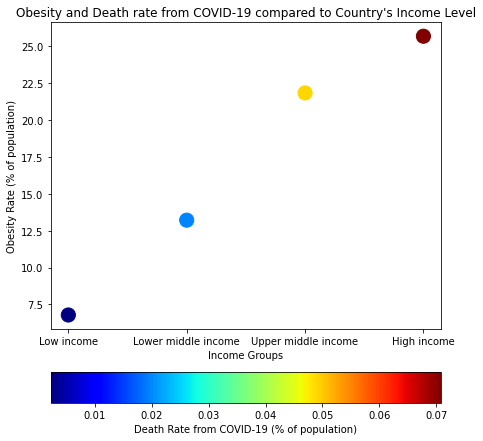

In [67]:
#Income nominal categories with plotted line for obesity and the death rate averages as coloured circles.
#NOTE: df_merged is a pandas dataframe that is the same as the original data schema.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

temp_df = df_merged.groupby('IncomeGroup').mean()
temp_df = temp_df.drop(["Confirmed","Recovered","Population"],axis=1)

obesity_temp = temp_df["Obesity"].to_numpy()
deaths_temp = temp_df["Deaths"].to_numpy()

obesity = [obesity_temp[1],obesity_temp[2],obesity_temp[3],obesity_temp[0]]
deaths = [deaths_temp[1],deaths_temp[2],deaths_temp[3],deaths_temp[0]]
brackets = ["Low income","Lower middle income","Upper middle income","High income"]

fig = plt.figure(figsize=(7,7))
ax = plt.subplot(111)
sc = plt.scatter(brackets,obesity, s = 200, c=deaths, cmap=plt.cm.jet)
plt.xlabel("Income Groups")
plt.ylabel("Obesity Rate (% of population)")
plt.title("Obesity and Death rate from COVID-19 compared to Country's Income Level")

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='10%', pad=0.6)
cbar = fig.colorbar(sc, cax=cax, orientation='horizontal') 
cax.set_xlabel('Death Rate from COVID-19 (% of population)') 

plt.plot(brackets, obesity)
plt.margins(x=0.1)
plt.show()

Chart insights: The chart confirms the previous finding that higher obesity rates are associated with higher COVID-19 death rates, but shows no clear correlation between the undernourishment rate and death rate. In this case the null result is useful as it indicates that undernourishment rate is not a significant factor in the mortality rate from COVID-19 and should therefore not be a main focus of the stakeholders.

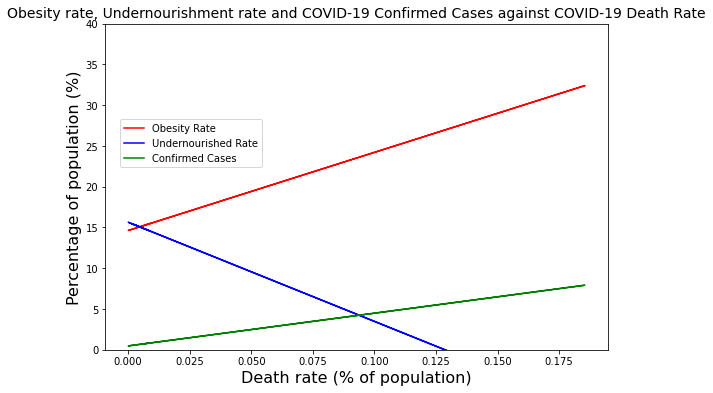

In [75]:
# The four attributes chart: Plots obesity rate, undernourished rate and confirmed cases against death rate.
# All 4 attributes are a percentage of total population.
#NOTE: To see imports see source code in .zip folder:

df_merged_copy = pd.read_csv("luke_dataset.csv")

#plot using matplotlib
fig,axes = plt.subplots(1,1,figsize = (9,6))  # initialise and set size
fig.subplots_adjust(hspace=0.4, wspace=0.4)  # add some extra whitespace for readability
plt.title("Obesity rate, Undernourishment rate and COVID-19 Confirmed Cases against COVID-19 Death Rate",fontsize=14)

axes.set_xlabel('Death rate (% of population)',fontsize=16)    
axes.set_ylabel('Percentage of population (%)',fontsize=16)

z = np.polyfit(df_merged_copy['Deaths'], df_merged_copy['Obesity'], 1)
p = np.poly1d(z)
plt.plot(df_merged_copy['Deaths'],p(df_merged_copy['Deaths']),"r",label=r'Obesity Rate')

z = np.polyfit(df_merged_copy['Deaths'], df_merged_copy['Undernourished'], 1)
p = np.poly1d(z)
plt.plot(df_merged_copy['Deaths'],p(df_merged_copy['Deaths']),"b",label=r'Undernourished Rate')

z = np.polyfit(df_merged_copy['Deaths'], df_merged_copy['Confirmed'], 1)
p = np.poly1d(z)
plt.plot(df_merged_copy['Deaths'],p(df_merged_copy['Deaths']),"g",label=r'Confirmed Cases')

axes.set_ylim(0, 40)
fig.legend(loc ='upper left',borderaxespad = 12) # include a legend
plt.show()  # and plot the figure

The report explored a multitude of different factors that impact a country’s mortality rate to COVID-19. Based on the chart above, lowering the rate of obesity should be the primary concern of stakeholders to reduce the chance of COVID-19 mortality.

However, there are limitations within this research. Firstly, the COVID-19 mortality rate is a complex issue to investigate as there are a very large number of factors that contribute to it. This research has only investigated a small number of factors, so it is likely that many more major factors exist that have not been considered. Moreover, the research used mortality data from 2020 which was quite early in the COVID-19 pandemic. Many countries in 2020 were not reporting COVID-19 deaths accurately. Therefore, the reliability and usefulness of the research could be improved if more recent COVID-19 mortality rate data was used.  

Ultimately, the report provided insight into some of the major factors that influence the COVID-19 mortality rate for countries around the world that is helpful for improving the health and wellbeing of the identified stakeholders. However, further research into more recent COVID-19 data is recommended to further benefit the stakeholders.